In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch import nn
from torch.nn import functional as F
import torch
import numpy as np
import random
from utils import evaluate_mcdropout as evaluate, rotate, grid_show_imgs

torch.manual_seed(0)
np.random.seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

data_dir = '~/datasets'
batch_size = 128
dropout = 0.5

In [2]:
# ===== 数据准备
full_ds = MNIST(data_dir, train=True, download=True,
                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))]))
train_ds, val_ds = random_split(full_ds, [55000, 5000])

test_ds = MNIST(data_dir, train=False, download=True,
                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))]))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
batch_num=len(train_dl)         # 小批量总数

In [3]:
# ===== 模型定义
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, inputs):
        outputs = F.dropout(self.conv1(inputs), p=dropout, training=True)   # dropout
        outputs = F.relu(F.max_pool2d(outputs, 2))
        outputs = F.dropout(self.conv2(outputs), p=dropout, training=True)  # dropout
        outputs = F.relu(F.max_pool2d(outputs, 2))
        outputs = self.flatten(outputs)
        outputs = F.relu(self.fc1(outputs))
        outputs = F.dropout(outputs, training=True)                         # dropout
        outputs = self.fc2(outputs)
        return outputs

model = Model().to(device)
# 优化器
opt = Adam(model.parameters(), lr=0.001)
# 损失
loss_fn = nn.CrossEntropyLoss()

In [4]:
# ===== 训练
epochs = 3
for epoch in range(epochs):                                                         # 算法2：第2行
    for batch, (batch_x, batch_y) in enumerate(train_dl):
        opt.zero_grad()
        model_out = model(batch_x)
        loss = loss_fn(model_out, batch_y)
        loss.backward()                                                             # 算法2：第9行
        opt.step()                                                                  # 第法2：第12行
        if batch % 100 == 0:
            acc = evaluate(model, val_dl, sample_num=1)  # 验证时仅做1次采样
            print(f'epoch: {epoch+1:>2}/{epochs:<2} batch: {batch+1:>4}/{batch_num:<4} Loss: {loss.item():.8}\tValid Acc: {acc: .6}')
            model.train()

epoch:  1/3  batch:    1/430  Loss: 2.3690267	Valid Acc:  0.1212
epoch:  1/3  batch:  101/430  Loss: 0.63241595	Valid Acc:  0.8188
epoch:  1/3  batch:  201/430  Loss: 0.44977346	Valid Acc:  0.8766
epoch:  1/3  batch:  301/430  Loss: 0.1762372	Valid Acc:  0.9074
epoch:  1/3  batch:  401/430  Loss: 0.19660956	Valid Acc:  0.9164
epoch:  2/3  batch:    1/430  Loss: 0.20512137	Valid Acc:  0.9186
epoch:  2/3  batch:  101/430  Loss: 0.35739562	Valid Acc:  0.9204
epoch:  2/3  batch:  201/430  Loss: 0.25500894	Valid Acc:  0.933
epoch:  2/3  batch:  301/430  Loss: 0.19113214	Valid Acc:  0.9326
epoch:  2/3  batch:  401/430  Loss: 0.22407523	Valid Acc:  0.9358
epoch:  3/3  batch:    1/430  Loss: 0.096975259	Valid Acc:  0.9372
epoch:  3/3  batch:  101/430  Loss: 0.13909075	Valid Acc:  0.9364
epoch:  3/3  batch:  201/430  Loss: 0.18382888	Valid Acc:  0.9438
epoch:  3/3  batch:  301/430  Loss: 0.31573042	Valid Acc:  0.9426
epoch:  3/3  batch:  401/430  Loss: 0.10938396	Valid Acc:  0.9432


In [7]:
# ==== 测试、可视化
sample_num = 20  # 50次采样
test_acc = evaluate(model, test_dl, sample_num)
print(f"Test acc with MCDropout: {test_acc:.6}")

Test acc with MCDropout: 0.9787


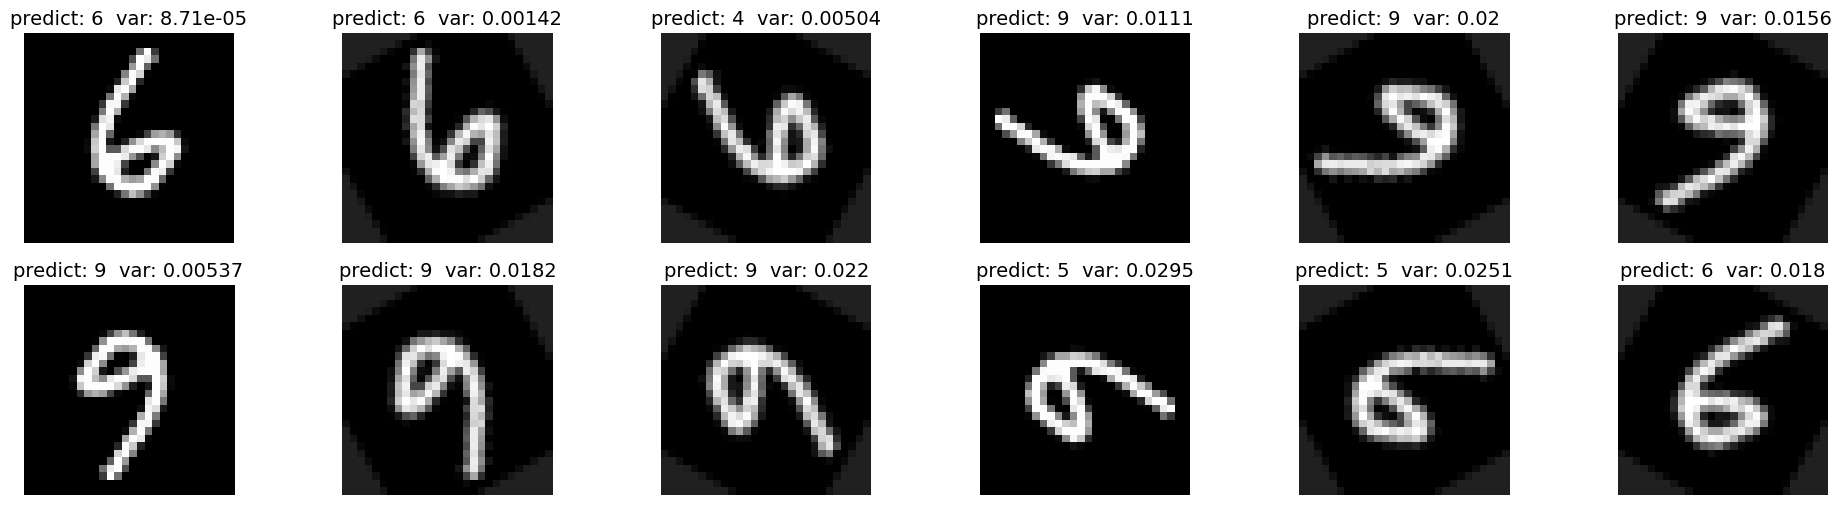

In [6]:
# 从测试集中随机选择一个数据
img = random.choice(test_ds)
imgs = rotate(img[0], angle=30)                                  # 旋转图像
model.eval()
preds = [model(imgs).detach().cpu() for _ in range(sample_num)]  # 多次采样
preds = torch.stack(preds, dim=-1).softmax(dim=1)
mean_preds = preds.mean(dim=-1).argmax(dim=1)                    # 预测的均值
preds_var = preds.var(dim=-1).mean(dim=1)                        # 预测的方差

infos = [f'predict: {p.item()}  var: {v.item():.3}' for p, v in zip(mean_preds, preds_var)]
grid_show_imgs(imgs, infos=infos)